<a href="https://colab.research.google.com/github/carlocamilloni/Structural-Bioinformatics/blob/main/Notebooks/lab02_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Dynamics simulation with GROMACS

The goal of this experience is to run some Molecular Dynamics simulations of simple systems and analyze them, in particular we will focus on water and alanine dipeptide

## Preliminary setup

In [ ]:
# mount google drive  
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Make a new folder for this task using the menus on the left side: for example in /drive/MyDrive/Structural_Bioinformatics make a folder named Task2. 

In [ ]:
# set the path to your local task folder
local_path='/content/drive/MyDrive/Structural_Bioinformatics/Task2'
%cd {local_path}

In [ ]:
# install gromacs
# gromacs is a molecular dynamics open source software
!apt update
!apt install gromacs

The next cell may take long to install, but ideally you will not need to repeat it the next time

In [ ]:
# test the gromacs executable
!gmx

In [ ]:
# make a copy of the GitHub structural bioinformatics repository
!git clone https://github.com/carlocamilloni/Structural-Bioinformatics.git sb --depth 1

All GROMACS tools are modules of a binary named "gmx". To get help about any GROMACS module, you can invoke either of the following commands:

gmx help (module)

or

gmx (module) -h

where (module) is replaced by the actual name of the command you're trying to issue. A full list of GROMACS modules can be printed by

gmx help commands

###Units

Basic units in GROMACS are 

Time: ps

Space: nm

Energy: kJ/mol


## Molecular Dynamics of water

In the following you will setup a MD simulation of a small water box and calculate some water property:

### system preparation

In [ ]:
# copy a water box file with 216 molecules in a cubic box:
%cd {local_path}
%mkdir water
%cd water
%cp /usr/share/gromacs/top/spc216.gro .

The first step is to generate the

*   Starting coordinates file
*   Topology file that includes the choice of the force field

this is done in gromacs using the tool `pdb2gmx`:

In [ ]:
# here we are using amber03 as a force field and spce as the water model:
!gmx pdb2gmx -f spc216.gro -ff amber03 -water spce

In [ ]:
%ls

There should be two new files: 

* conf.gro: starting coordinates in gromacs format
* topol.top: topology file including relevant parameters and force-field choice.

If you open topol.top (these are all text files) you can see that is very simple in this case.

In principle now we should generate the box, but in this case we are already starting from a box of water molecules, you can see the box size at the bottom of the conf.gro file:

In [ ]:
!tail conf.gro

box: 1.86206   1.86206   1.86206

This means that is a cubic box of side 1.862 etc

### energy minimization:

In [ ]:
# to perform simulations we also need a simulation parameter file
%cp ../sb/Data/md/mdps/0-em-steep.mdp {local_path}/water

In [ ]:
#then we need to generate a simulation package file that put togheter the starting configuration, the topology and the simulation parameter file:
!gmx grompp -f 0-em-steep.mdp -c conf.gro -p topol.top -o em.tpr

In [ ]:
#run the energy minimization:
!gmx mdrun -s em.tpr -v

### MD

In [ ]:
#now we are ready to setup the first simple MD
%cp ../sb/Data/md/mdps/npt-water.mdp {local_path}/water

The file you have just copied includes the specific parameter of the simulation you are going to run, like the length of the simulation, the temperature, ecc.

In the left menu you can double click on the file to read it/edit it ecc. 

In [ ]:
#preparation
!gmx grompp -f npt-water -c confout -p topol -o md-water.tpr

In [ ]:
# run the simulation, this will take 2-3 minutes
!gmx mdrun -v -deffnm md-water

### Visualisation

Once the simulation is ended you should have few more files:

In [ ]:
%ls

*   md-water.xtc: trajectory file
*   md-water.edr: energy file including all the information about energy
*   md-water.gro: last frame of the trajectory
*   md-water.cpt: checkpoint file for exact restart

You can look at the trajectory using VMD on your laptop, first load a `conf.gro` then from the menu FILE choose *Load Data Into Molecule* and select the `md-water.xtc` file, this will add all the trajectory frames. You may see something like this:

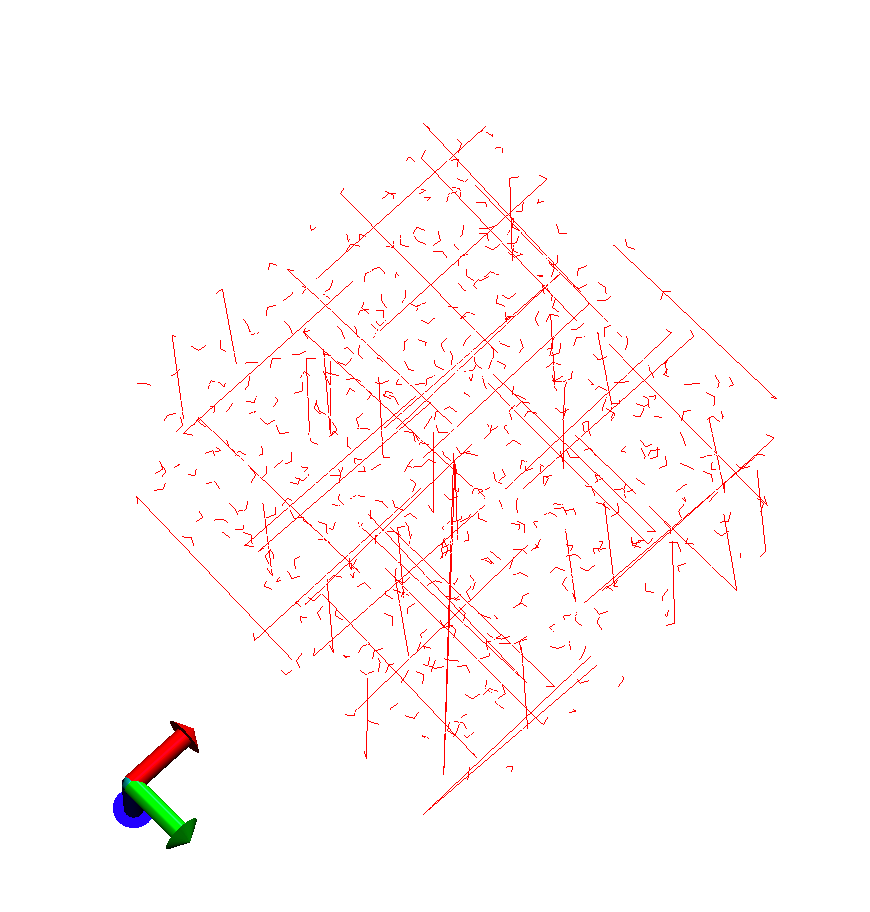

You remember the “PERIODIC BOUNDARY CONDITIONS”? A molecule of water can be cut across the sides of the box. For the purpose of visualisation, we can remove this effect:

In [ ]:
!echo -e "0\n" | gmx trjconv -f md-water.xtc -s md-water.tpr -pbc mol -o md-water-nobpc.xtc

This command is a bit complicated because the notebooks are not interactive so if we need to select an option, we need to tell it to the program as above:

`echo -e “0\n” |` -> this means after the program that follow is started press “0”.

Anyway, now you have one more file `md-water-nopbc.xtc` that is the trajectory with molecules that are not broken across PBC. Close VMD and reopen it. Now we can start to analyse the trajectory

### Analysis

**DENSITY**, to calculate the density and many other properties we can again use a GROMACS module:



In [ ]:
!echo -e "5\n15\n16\n18\n" | gmx energy -f md-water.edr -s md-water 


This will generate a file named `energy.xvg` with as many columns as the properties selected. Here:
`-nmol 256` indicates how many molecules are in the simulations
`-fluct_props` tell the program to calculate fluctuations (see my slides on how to calculate some of the resulting properties).

This will calculate the density over time, total energy, enthalpy and temperature and derive simple properties from it (heat capacity and enthalpy of vaporisation).

Try to generate the plot for all of them and compare the result with the number reported in the tables, be careful about the units.

To plot more than one set in the same plot you can do something like this:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]
y3=[]
y4=[]

with open('energy.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))
        y2.append(float(row.split()[2]))
        y3.append(float(row.split()[3]))
        y4.append(float(row.split()[4]))


# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2,2)
figure.set_size_inches(18.5, 10.5)

axis[0,0].plot(x, y1)
axis[0,0].set_title("Potential Energy")

axis[1,0].plot(x, y2)
axis[1,0].set_title("Volume")

axis[0,1].plot(x, y3)
axis[0,1].set_title("Density")

axis[1,1].plot(x, y4)
axis[1,1].set_title("Entalphy")

plt.show()


Now we calculate the radial distribution function

In [ ]:
# we generate a selection of the oxygen atoms
!echo -e 'aOW\nq\n' | gmx make_ndx -f md-water.tpr

In [ ]:
!echo -e "3\n3\n" |gmx rdf -f md-water -s md-water -n index

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]

with open('rdf.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots()
figure.set_size_inches(18.5, 10.5)

axis.plot(x, y1)
axis.set_title("RDF")

plt.show()

## Molecular Dynamics of Alanine Dipeptide in vacuum

This is alanine-dipeptide:

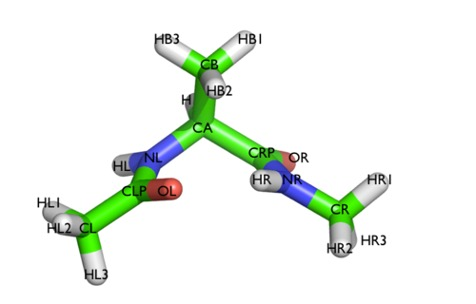

The PDB structure for this system is in MD-examples/alanine-dipeptide, first of all copy the file in your folder. 



In [ ]:
%cd {local_path}
%mkdir aladp
%cd aladp
%cp ../sb/Data/md/inputs/aladp.pdb .

Now, if you remember the steps for beginning an MD simulations they were more or less:

1)	Chose a force-field 

2)	Setting the box and the solution conditions

3)	Energy minimization

4)	Simulation

So, from the beginning, the first step is to “translate” the PDB structure in the GROMACS format, while at the same time we set the force-field. This is done interactively using the GROMACS module `pdb2gmx`, here we chose the first force field in the list and we don’t choose any specific model of water because we will run the simulation in vacuum:

### System preparation

In [ ]:
!gmx pdb2gmx -f aladp.pdb -water none -ff amber03

From the output you will see that we have selected the force field “AMBER03”, you can also see some information about the system.

Now in the folder you have some more files:

-	conf.gro: the alanine dipeptide structure in the gromacs format
-	topol.top: a topology file including all the information about the force field
-	posre.itp: this is a file that can be used to restrain the position of the atoms (we will not use it).

Now moving to the second step we need to define the BOX of our simulation


In [ ]:
!gmx editconf -f conf.gro -bt cubic -d 1 -o boxed.gro

We are putting our molecule in a cubic box whose side are at least 1 nm far from the surface of our molecule. boxed.gro is the resulting output file.

At this point one would fill the box with the solution, but we are working in vacuum so we skip this step.

So we prepare the system for energy minimization:


### Energy minimisation

In [ ]:
%cp ../sb/Data/md/mdps/0-em-steep.mdp em.mdp

In [ ]:
!gmx grompp -f em.mdp -c boxed.gro -p topol.top -o em.tpr
!gmx mdrun -deffnm em -v

The first command merges all the information of the em.mdp, boxed.gro and topol.top files into a single file that will be used to run the simulation: em.tpr. In the file em.mdp there are all the details about the simulation algorithms.

The second command executes the energy minimization, this lasts only few steps


Now there is a em.gro file that is the energy minimized structure:

### Molecular dynamics

In [ ]:
%cd {local_path}/aladp
%cp ../sb/Data/md/mdps/run.mdp .

In [ ]:
!gmx grompp -f run.mdp -c em.gro -p topol.top -o run.tpr
!gmx mdrun -deffnm run -v -nb cpu -ntmpi 1 -ntomp 1

### Visualisation

The simulation will take around 1 minute to perform 10 ns.

To visualise the simulation, you can copy the `run.xtc` and `em.gro` files on your workstation. Open the `em.gro` file with VMD and then load into the `run.xtc` file.

### Analysis

In [ ]:
!gmx chi -f run.xtc -s run.tpr -phi -psi -rama -all

In [ ]:
%ls

This will write a `psiALA2.xvg` and `phiALA2.xvg` files that include the time evolution of the phi and psi angles:

You can plot both as a function of the frame 


In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('phiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

with open('psiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        y2.append(float(row.split()[1]))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2)

axis[0].plot(y1)
axis[0].set_ylabel("PHI")

axis[1].plot(y2)
axis[1].set_ylabel("PSI")
axis[1].set_xlabel("Time (ps)")

plt.show()


or one against the other as in the Ramachandran plot:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('ramaPhiPsiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

plt.scatter(x,y1)

plt.xlabel('')
plt.ylabel('')

plt.show()

There are also histograms:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('histo-phiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

with open('histo-psiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        y2.append(float(row.split()[1]))


figure, axis = plt.subplots(2)

axis[0].plot(x,y1)
axis[0].set_xlabel("PHI")

axis[1].plot(x,y2)
axis[1].set_xlabel("PSI")

plt.show()

# Report Template

Start by creating a new notebook, using **File -> New Notebook**. New notebooks are created in your google drive, in a **Colab Notebooks** folder.

When you are in the new notebook, generally named "Untitled.ipynb", select **File -> Move** and move it to your Task2 folder.

Rename the notebook as Visualisation.ipynb

You can then copy and paste the following cells and then modify them as appropriate. The resulting notebook will be your first report.

# Molecular Dynamics Simulations

Your Name

In [ ]:
from datetime import date

today = date.today()
print(today)

##Water

In [ ]:
%cd {local_path}/water

In [ ]:
#add a figure of the system

**Figure 1**: Describe the system, Add here the details of the simulation you performed:


*   Force Field and Water Model
*   Box Size
*   Number of molecules
*   Temperature
*   Length of the simulation

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]
y3=[]
y4=[]

with open('energy.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))
        y2.append(float(row.split()[2]))
        y3.append(float(row.split()[3]))
        y4.append(float(row.split()[4]))


# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2,2)
figure.set_size_inches(18.5, 10.5)

axis[0,0].plot(x, y1)
axis[0,0].set_ylabel("Potential Energy")

axis[1,0].plot(x, y2)
axis[1,0].set_ylabel("Volume")
axis[1,0].set_xlabel("Time (ps)")

axis[0,1].plot(x, y3)
axis[0,1].set_ylabel("Density")

axis[1,1].plot(x, y4)
axis[1,1].set_ylabel("Entalphy")
axis[1,1].set_xlabel("Time (ps)")


plt.show()

**Figure 2.** Describe the content of the figure above:

In [ ]:
from numpy.ma.extras import average
#Try to calculate the enthaly of vaporisation and the specific heat using the equations in the PDF
#You have all the needed data above:
# y1 includes all the values for the potential energy
# y3 those for the volume
# y4 those for the enthalpy
# you need to calculate properties like average and standard deviation and use the number of molecules in your system
# the pressure is 10^5 N/m^2
import numpy as np

#for example for the enthalpy of vaporisation you can do:
mean_U = average(y1)
mean_Usquare = average(np.array(y1)**2) 
mean_V = average(y3)*pow(10,-27) # to transform it to m^3
print(mean_U, mean_Usquare, mean_V)
nmol = 216
RT=2.45
NA=6.022*pow(10,23)
p=pow(10,5)
hv = -mean_U/nmol+RT-p*mean_V
print("The enthalpy of vaporisation is:", hv, "kJ/mol")


In [ ]:
#try to calculate the heat capacity
#here you need to use enthalpy that is y4
mean_H = average(y4)
mean_Hsquare = average(np.array(y4)**2)
T=293
nmol=216
kb=0.0083
# write the correct formula below and uncomment
#cp=
print("The heat capacity is:", cp*1000, "J/mol/K")

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]

with open('rdf.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots()
figure.set_size_inches(18.5, 10.5)

axis.plot(x, y1)
axis.set_ylabel("RDF")
axis.set_xlabel("Radius (nm)")

plt.show()

**Figure 3.** Describe the content of the figure above:

## Alanine Dipeptide

In [ ]:
%cd {local_path}/aladp

In [ ]:
#Add here a figure of the system

**Figure 4.** Describe the system and add here the details of the simulation you performed:


*   Force Field
*   Box Size
*   Temperature
*   Length of the simulation

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('ramaPhiPsiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

plt.scatter(x,y1)

plt.xlabel('')
plt.ylabel('')

plt.show()

**Figure 5**: describe the figure

In [ ]:
import matplotlib.pyplot as plt
import csv

angle=[]
c_phi=[]
c_psi=[]

with open('histo-phiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        angle.append(float(row.split()[0]))
        c_phi.append(float(row.split()[1]))

with open('histo-psiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        c_psi.append(float(row.split()[1]))

n_phi = np.array(c_phi)
n_psi = np.array(c_psi)


print(angle)
print(n_phi)
print(n_psi)
#angle is the information about the binning of the histograms
#n_phi is the normalised count of frames in the corresponding bin for the phi angle
#n_psi is the normalised count of frames in the corresponding bin for the psi angle

In [ ]:
# Now how can you get Free Energy profiles from the above 1D histograms?
# complete and uncomment the following lines
# you can calculate the log of a list as np.log()
kbT = 0.0083*293
#f_phi = 
#f_psi = 

In [ ]:
figure, axis = plt.subplots(2)

axis[0].plot(angle,f_phi)
axis[0].set_xlabel("Phi")
axis[0].set_ylabel("Free Energy (kJ/mol)")

axis[1].plot(angle,f_psi)
axis[1].set_xlabel("Psi")
axis[1].set_ylabel("Free Energy (kJ/mol)")

plt.show()

**Figure 6**: describe the figure